In [32]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [74]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [75]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = -kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def system(t, state):
    dydt = np.zeros_like(state)
    dydt[0] = p_change(t, *state)
    dydt[1] = m_change(t, *state)
    dydt[2] = M_free_change(t, *state)
    dydt[3] = M_bound_change(t, *state)
    dydt[4] = n_change(t, *state)
    return dydt

In [76]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 50, 10, 10, 20, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [77]:
samlet_løsning = solve_ivp(system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.004e-01 ...  4.991e+03  5.000e+03]
        y: [[ 5.000e+01  5.026e+01 ...  6.226e+01  6.725e+01]
            [ 1.000e+01  1.010e+01 ...  3.268e+01  3.770e+01]
            ...
            [ 2.000e+01  1.994e+01 ... -1.276e-06 -2.240e-07]
            [ 1.000e+00  9.928e-01 ...  1.183e-06  2.064e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4016
     njev: 0
      nlu: 0


In [78]:
t, p, m, Mf, Mb, n = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

In [83]:
print(t[0])

0.0


[]

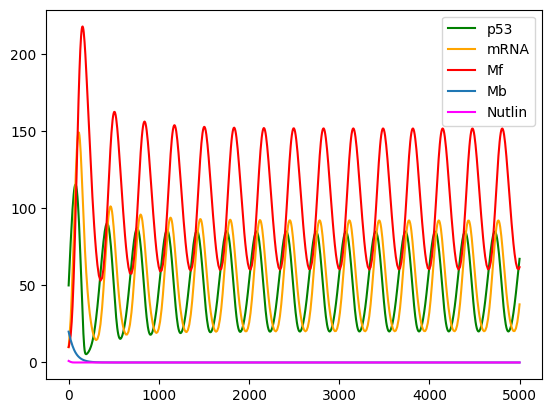

In [82]:
plt.plot(t, p, color="green", label="p53")
plt.plot(t, m, color="orange", label="mRNA")
plt.plot(t, Mf, color="red", label="Mf")
plt.plot(t,Mb, label="Mb")
plt.plot(t, n, color="magenta", label="Nutlin")

plt.legend()
plt.plot()

Hvorfor eksploderer mængden af `Mb`?

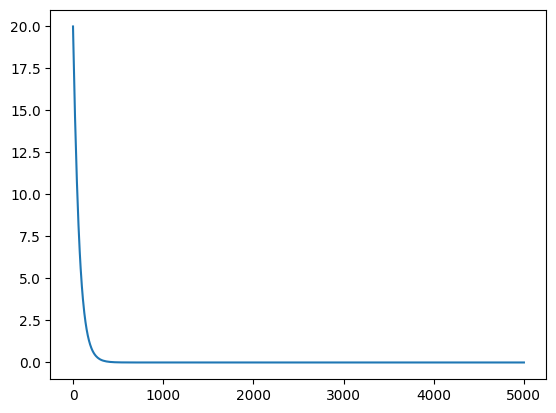

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

### Period and amplitude

In [70]:
def find_map(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [71]:
period, amplitude, mean_value, stable_peaks, stable_troughs = find_map(t, p)

In [72]:
print(period, amplitude, mean_value)

330.30817859459324 32.378255262715186 52.50351512183449


Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 330.3081786 [min]')

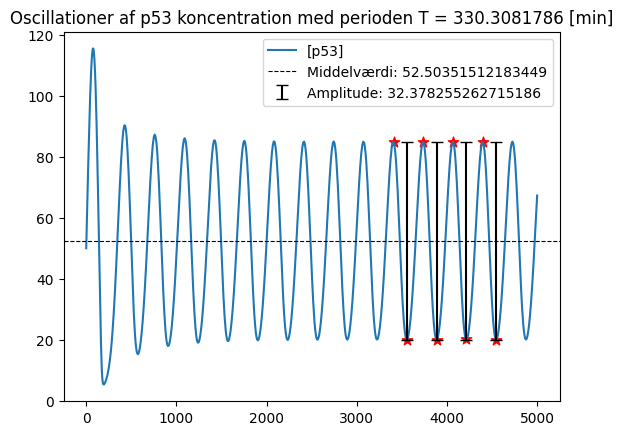

In [73]:
plt.plot(t, p, label="[p53]")
plt.scatter(t[stable_peaks], p[stable_peaks], s=60, c="red", marker='*')
plt.scatter(t[stable_troughs], p[stable_troughs], s=60, c="red", marker='*')

plt.axhline(mean_value, color="black", linestyle="dashed", lw=.8, label=f"Middelværdi: {mean_value}")
plt.errorbar(t[stable_troughs], np.ones(len(t[stable_troughs]))*mean_value, yerr=amplitude, fmt="none", ecolor="black", capsize = 4, label=f"Amplitude: {amplitude}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.10} [min]")